# DA9 Preprocess
Created: 04/05/2024 \
Updated: 04/05/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'DA9'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA9/raw/DA09_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535999  =      0.000 ...  1499.999 secs...


In [7]:
mne_data

<RawEDF | DA09_SWB.edf, 64 x 1536000 (1500.0 s), ~750.1 MB, data loaded>

In [8]:
mne_data.ch_names

['EEG LAD1-REF',
 'EEG LAD2-REF',
 'EEG LAD3-REF',
 'EEG LAD4-REF',
 'EEG LAD5-REF',
 'EEG LAD6-REF',
 'EEG LAD7-REF',
 'EEG LAD8-REF',
 'EEG LHD1-REF',
 'EEG LHD2-REF',
 'EEG LHD3-REF',
 'EEG LHD4-REF',
 'EEG LHD5-REF',
 'EEG LHD6-REF',
 'EEG LHD7-REF',
 'EEG LHD8-REF',
 'EEG LHD9-REF',
 'EEG LFP1-REF',
 'EEG LFP2-REF',
 'EEG LFP3-REF',
 'EEG LFP4-REF',
 'EEG LFP5-REF',
 'EEG LFP6-REF',
 'EEG LFP7-REF',
 'EEG LFP8-REF',
 'EEG LFP9-REF',
 'EEG RFP1-REF',
 'EEG RFP2-REF',
 'EEG RFP3-REF',
 'EEG RFP4-REF',
 'EEG RFP5-REF',
 'EEG RFP6-REF',
 'EEG RFP7-REF',
 'EEG RFP8-REF',
 'EEG RFP9-REF',
 'EEG RHD1-REF',
 'EEG RHD2-REF',
 'EEG RHD3-REF',
 'EEG RHD4-REF',
 'EEG RHD5-REF',
 'EEG RHD6-REF',
 'EEG RHD7-REF',
 'EEG RHD8-REF',
 'EEG RHD9-REF',
 'EEG RIL1-REF',
 'EEG RIL2-REF',
 'EEG RIL3-REF',
 'EEG RIL4-REF',
 'EEG RIL5-REF',
 'EEG RIL6-REF',
 'EEG RIL7-REF',
 'EEG RIL8-REF',
 'Air NASAL-REF',
 'EEG 1-REF',
 'EEG 2-REF',
 'EEG EKG_L-REF',
 'EEG EKG_R-REF',
 'EEG EKG_LT_LEG-R',
 'EEG EKGV1-R

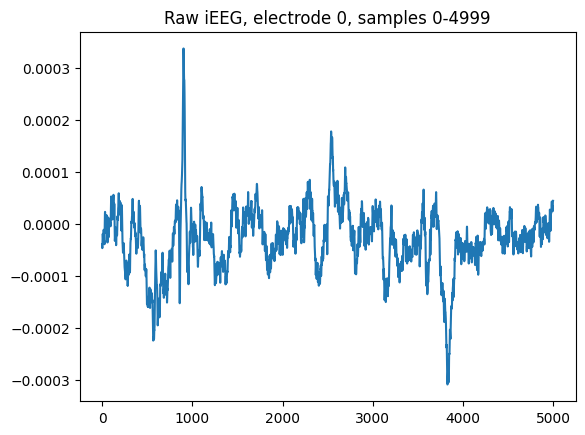

In [72]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Photodiode
- examine photodiode 

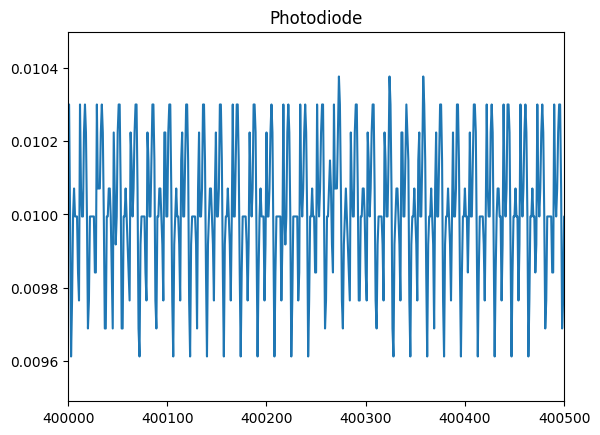

In [9]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("Stim TEST2-REF")
# plt.plot(scipy.stats.zscore(mne_data._data[trig_ix,:]))
plt.plot(np.abs(mne_data._data[trig_ix,:]))
# plt.ylim([-2,2.5])
plt.xlim([400000,400500])
plt.title("Photodiode")
plt.show()

In [10]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode_edf.fif', picks='Stim TEST2-REF', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA9/photodiode_edf.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA9/photodiode_edf.fif
[done]


In [11]:
mne_data.drop_channels(['Stim TEST2-REF'])

<RawEDF | DA09_SWB.edf, 63 x 1536000 (1500.0 s), ~738.3 MB, data loaded>

### Resampling data 

In [12]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    4.1s finished


<RawEDF | DA09_SWB.edf, 63 x 750000 (1500.0 s), ~360.6 MB, data loaded>

### Notch filter line noise

In [13]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    1.6s finished


<RawEDF | DA09_SWB.edf, 63 x 750000 (1500.0 s), ~360.6 MB, data loaded>

### Anatomical Localization

In [14]:
def UCD_check_edf_names(ch_names):

    #loop through channel names
    clean_names = []
    for ch in ch_names:
        if 'EEG' in ch:
            clean_names.append(ch.replace('EEG ','').replace('-REF','').lower())
        elif 'EEG' not in ch:
            clean_names.append(ch.lower())
        else:
            clean_names.append(ch.lower())
    if not clean_names:
        print('There is a problem with your channel naming format.')
    
    return clean_names


In [15]:
clean_names = UCD_check_edf_names(mne_data.ch_names)

In [16]:
clean_names

['lad1',
 'lad2',
 'lad3',
 'lad4',
 'lad5',
 'lad6',
 'lad7',
 'lad8',
 'lhd1',
 'lhd2',
 'lhd3',
 'lhd4',
 'lhd5',
 'lhd6',
 'lhd7',
 'lhd8',
 'lhd9',
 'lfp1',
 'lfp2',
 'lfp3',
 'lfp4',
 'lfp5',
 'lfp6',
 'lfp7',
 'lfp8',
 'lfp9',
 'rfp1',
 'rfp2',
 'rfp3',
 'rfp4',
 'rfp5',
 'rfp6',
 'rfp7',
 'rfp8',
 'rfp9',
 'rhd1',
 'rhd2',
 'rhd3',
 'rhd4',
 'rhd5',
 'rhd6',
 'rhd7',
 'rhd8',
 'rhd9',
 'ril1',
 'ril2',
 'ril3',
 'ril4',
 'ril5',
 'ril6',
 'ril7',
 'ril8',
 'air nasal-ref',
 '1',
 '2',
 'ekg_l',
 'ekg_r',
 'ekg_lt_leg-r',
 'ekgv1',
 'ekgv5',
 'resp abd1-ref',
 'sao2-ref',
 'co2-ref']

In [17]:
clean_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, clean_names)}
mne_data.rename_channels(clean_name_dict)

<RawEDF | DA09_SWB.edf, 63 x 750000 (1500.0 s), ~360.6 MB, data loaded>

In [18]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x      mni_y  \
0   LAD1    mAmyg_L -17.471760  10.790956  -9.888621 -14.202810  -3.822049   
1   LAD2    mAmyg_L -22.261112  10.391291  -9.089589 -19.216283  -3.891958   
2   LAD3    mAmyg_L -27.449577  10.391291  -8.690073 -24.550816  -3.667518   
3   LAD4    lAmyg_L -32.238930   9.991626  -8.290558 -29.505896  -3.881665   
4   LAD5    Unknown -37.427395   9.591962  -7.491526 -34.980580  -3.964504   
5   LAD6     A38l_L -42.216747   9.192297  -7.092010 -40.067985  -4.078986   
6   LAD7     A22r_L -47.405212   8.792632  -6.292979 -45.629547  -4.036446   
7   LAD8     aSTS_L -52.194565   8.792632  -5.493947 -50.795900  -3.681195   
8   LFP1     A11m_L -19.068211  44.362791  -1.498790 -13.605498  34.223324   
9   LFP2    Unknown -19.866436  42.364467   2.895883 -15.002357  33.627828   
10  LFP3    Unknown -20.664661  40.366144   7.290557 -16.498716  32.961508   
11  LFP4    Unknown -21.462887  38.367820  11.685230 -17.896326  32.241880   
12  LFP5    Unknown -21.862000  36.769161  16.878934 -18.765129  32.166487   
13  LFP6    Unknown -22.660225  34.770838  21.273608 -20.050368  31.353275   
14  LFP7    Unknown -23.857563  32.772514  25.268765 -21.760849  30.379224   
15  LFP8    Unknown -24.256676  31.173856  30.062954 -22.613241  29.946276   
16  LFP9   A9/46d_L -24.655788  29.974861  35.256659 -23.295524  29.836396   
17  LHD1    rHipp_L -36.230057  -2.797644  -5.094432 -34.312688 -16.251584   
18  LHD2    Unknown -41.019409  -4.396303  -4.295400 -39.396530 -17.576591   
19  LHD3    Unknown -45.409649  -5.595297  -3.496369 -44.072953 -18.543409   
20  LHD4     aSTS_L -50.199001  -6.794291  -2.297821 -49.255988 -19.508036   
21  LHD5     aSTS_L -54.988354  -7.993285  -1.498790 -54.425407 -20.610042   
22  LHD6     aSTS_L -59.777706  -9.192279  -0.300243 -59.550769 -21.491734   
23  LHD7     aSTS_L -64.567059 -10.391273   0.898305 -64.624660 -22.280998   
24  LHD8     aSTS_L -68.558186 -11.190603   1.697336 -68.825188 -22.750754   
25  LHD9    Unknown -72.549313 -12.789261   2.895883 -73.144394 -23.984211   
26  RFP1    Unknown   4.878551  40.765808   1.697336  10.846384  30.853666   
27  RFP2    Unknown   6.075890  38.767485   5.292978  11.722088  30.042421   
28  RFP3    Unknown   8.071453  37.568491  10.087167  13.597677  30.518742   
29  RFP4    Unknown   9.667904  35.570167  14.082324  15.041016  29.799940   
30  RFP5    Unknown  11.663467  34.371173  18.876513  16.990206  29.929020   
31  RFP6    Unknown  13.659031  32.772514  22.871671  18.866793  29.279425   
32  RFP7    Unknown  16.053707  31.173856  27.665860  21.120242  28.797799   
33  RFP8    Unknown  17.251045  29.575197  31.661017  22.071351  28.134712   
34  RFP9   A9/46d_R  19.246609  27.976538  36.055690  23.882084  27.546696   
35  RHD1    cHipp_R  34.812004 -10.790938 -13.484262  40.723022 -26.952923   
36  RHD2     aSTS_R  39.601357 -10.391273 -11.486684  45.545864 -25.881057   
37  RHD3     aSTS_R  43.592484  -9.991609 -10.288136  49.543954 -25.118672   
38  RHD4     aSTS_R  48.780949  -9.591944  -7.491526  54.620256 -24.186540   
39  RHD5     aSTS_R  53.570301  -8.392950  -5.493947  59.551193 -22.822514   
40  RHD6     A22r_R  57.162315  -7.993285  -3.895884  63.292082 -22.341744   
41  RHD7     A22c_R  61.951668  -7.593620  -1.099274  68.271451 -21.637487   
42  RHD8     A22c_R  65.942795  -7.193956   1.697336  72.442717 -20.729836   
43  RHD9    Unknown  69.933922  -7.193956   4.493946  76.581292 -20.173621   
44  RIL1    A20il_R  47.982723  -7.593620 -19.476999  55.340824 -25.841855   
45  RIL2     A21c_R  51.973850  -6.794291 -16.680388  59.359762 -24.223515   
46  RIL3     A21c_R  56.364090  -5.994962 -13.883778  63.690374 -22.824994   
47  RIL4     aSTS_R  60.355217  -5.195632 -11.087168  67.518223 -21.511448   
48  RIL5     aSTS_R  64.745457  -4.396303  -8.690073  71.885769 -20.352771   
49  RIL6    Unknown  67.938358  -3.596973  -6.292979  75.117796 -19.043512   
50  RIL7    Unknown  71.5

In [19]:
list(elec_locs.label)

['LAD1',
 'LAD2',
 'LAD3',
 'LAD4',
 'LAD5',
 'LAD6',
 'LAD7',
 'LAD8',
 'LFP1',
 'LFP2',
 'LFP3',
 'LFP4',
 'LFP5',
 'LFP6',
 'LFP7',
 'LFP8',
 'LFP9',
 'LHD1',
 'LHD2',
 'LHD3',
 'LHD4',
 'LHD5',
 'LHD6',
 'LHD7',
 'LHD8',
 'LHD9',
 'RFP1',
 'RFP2',
 'RFP3',
 'RFP4',
 'RFP5',
 'RFP6',
 'RFP7',
 'RFP8',
 'RFP9',
 'RHD1',
 'RHD2',
 'RHD3',
 'RHD4',
 'RHD5',
 'RHD6',
 'RHD7',
 'RHD8',
 'RHD9',
 'RIL1',
 'RIL2',
 'RIL3',
 'RIL4',
 'RIL5',
 'RIL6',
 'RIL7',
 'RIL8',
 'uLFP',
 'uLHD',
 'uRFP',
 'uRHD']

In [20]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['air nasal-ref', '1', '2', 'ekg_l', 'ekg_r', 'ekg_lt_leg-r', 'ekgv1', 'ekgv5', 'resp abd1-ref', 'sao2-ref', 'co2-ref']


In [21]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [22]:
unmatched_seeg #make sure there are no unmatched names


[]

In [23]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [24]:
new_name_dict #make sure this passes the eye test 


{'lad1': 'lad1',
 'lad2': 'lad2',
 'lad3': 'lad3',
 'lad4': 'lad4',
 'lad5': 'lad5',
 'lad6': 'lad6',
 'lad7': 'lad7',
 'lad8': 'lad8',
 'lhd1': 'lhd1',
 'lhd2': 'lhd2',
 'lhd3': 'lhd3',
 'lhd4': 'lhd4',
 'lhd5': 'lhd5',
 'lhd6': 'lhd6',
 'lhd7': 'lhd7',
 'lhd8': 'lhd8',
 'lhd9': 'lhd9',
 'lfp1': 'lfp1',
 'lfp2': 'lfp2',
 'lfp3': 'lfp3',
 'lfp4': 'lfp4',
 'lfp5': 'lfp5',
 'lfp6': 'lfp6',
 'lfp7': 'lfp7',
 'lfp8': 'lfp8',
 'lfp9': 'lfp9',
 'rfp1': 'rfp1',
 'rfp2': 'rfp2',
 'rfp3': 'rfp3',
 'rfp4': 'rfp4',
 'rfp5': 'rfp5',
 'rfp6': 'rfp6',
 'rfp7': 'rfp7',
 'rfp8': 'rfp8',
 'rfp9': 'rfp9',
 'rhd1': 'rhd1',
 'rhd2': 'rhd2',
 'rhd3': 'rhd3',
 'rhd4': 'rhd4',
 'rhd5': 'rhd5',
 'rhd6': 'rhd6',
 'rhd7': 'rhd7',
 'rhd8': 'rhd8',
 'rhd9': 'rhd9',
 'ril1': 'ril1',
 'ril2': 'ril2',
 'ril3': 'ril3',
 'ril4': 'ril4',
 'ril5': 'ril5',
 'ril6': 'ril6',
 'ril7': 'ril7',
 'ril8': 'ril8',
 'air nasal-ref': 'airnasal-ref',
 '1': '1',
 '2': '2',
 'ekg_l': 'ekg_l',
 'ekg_r': 'ekg_r',
 'ekg_lt_leg-r': 'ekg_

In [25]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | DA09_SWB.edf, 63 x 750000 (1500.0 s), ~360.6 MB, data loaded>

In [26]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 26 left sEEG and 27 right sEEG electrodes
We have a total of 53 sEEG electrodes


In [27]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | DA09_SWB.edf, 63 x 750000 (1500.0 s), ~360.6 MB, data loaded>

In [28]:
mne_data.ch_names

['lad1',
 'lad2',
 'lad3',
 'lad4',
 'lad5',
 'lad6',
 'lad7',
 'lad8',
 'lhd1',
 'lhd2',
 'lhd3',
 'lhd4',
 'lhd5',
 'lhd6',
 'lhd7',
 'lhd8',
 'lhd9',
 'lfp1',
 'lfp2',
 'lfp3',
 'lfp4',
 'lfp5',
 'lfp6',
 'lfp7',
 'lfp8',
 'lfp9',
 'rfp1',
 'rfp2',
 'rfp3',
 'rfp4',
 'rfp5',
 'rfp6',
 'rfp7',
 'rfp8',
 'rfp9',
 'rhd1',
 'rhd2',
 'rhd3',
 'rhd4',
 'rhd5',
 'rhd6',
 'rhd7',
 'rhd8',
 'rhd9',
 'ril1',
 'ril2',
 'ril3',
 'ril4',
 'ril5',
 'ril6',
 'ril7',
 'ril8',
 'airnasal-ref',
 '1',
 '2',
 'ekg_l',
 'ekg_r',
 'ekg_lt_leg-r',
 'ekgv1',
 'ekgv5',
 'respabd1-ref',
 'sao2-ref',
 'co2-ref']

In [29]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
drop_chans.append('respabd1-ref')
drop_chans

['ekgv5',
 'ekg_r',
 '1',
 'ekgv1',
 '2',
 'airnasal-ref',
 'ekg_lt_leg-r',
 'ekg_l',
 'co2-ref',
 'sao2-ref',
 'respabd1-ref']

In [30]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
drop_chans.append('respabd1-ref')
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | DA09_SWB.edf, 52 x 750000 (1500.0 s), ~297.6 MB, data loaded>

In [31]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | DA09_SWB.edf, 52 x 750000 (1500.0 s), ~297.6 MB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [32]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [33]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c
probe_ch_counts

{'lad': 8,
 'lfp': 9,
 'lhd': 9,
 'rfp': 9,
 'rhd': 9,
 'ril': 8,
 'ulfp': 1,
 'ulhd': 1,
 'urfp': 1,
 'urhd': 1}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [34]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['lad1', 'lhd1']

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


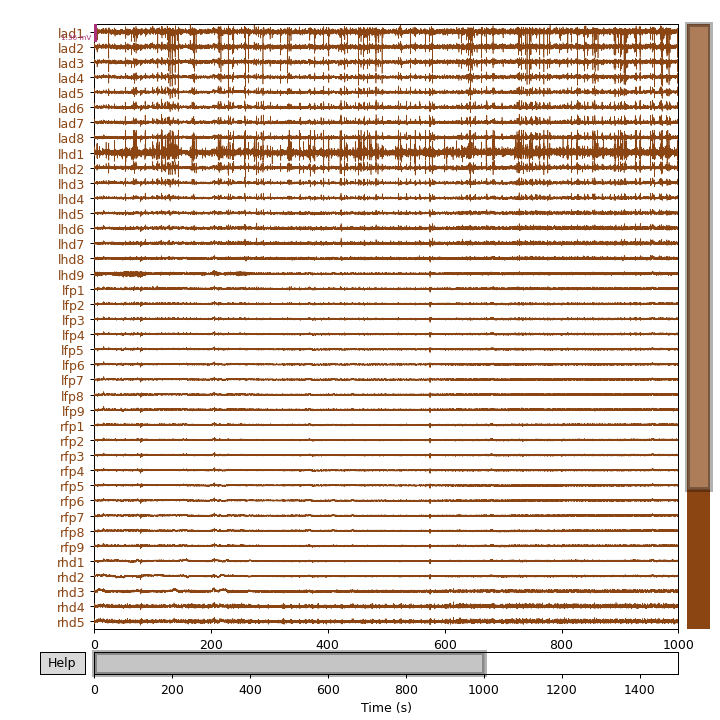

In [35]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=40, scalings=mne_data._data.max()/5)


In [36]:
mne_data.info['bads']

[]

In [37]:
mne_data.info #sanity check that bads info saved

<Info | 9 non-empty values
 bads: []
 ch_names: lad1, lad2, lad3, lad4, lad5, lad6, lad7, lad8, lhd1, lhd2, ...
 chs: 52 sEEG
 custom_ref_applied: False
 dig: 52 items (52 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 09:40:00 UTC
 nchan: 52
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [38]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [39]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=23, n_times=750000
    Range : 0 ... 749999 =      0.000 ...  1499.998 secs
Ready.
Added the following bipolar channels:
lad1-lad2, lad2-lad3, lad3-lad4, lad4-lad5, lad5-lad6, lad6-lad7, lad7-lad8, lfp7-lfp8, lfp8-lfp9, lhd3-lhd4, lhd4-lhd5, lhd5-lhd6, lhd6-lhd7, lhd7-lhd8, rhd1-rhd2, rhd2-rhd3, rhd3-rhd4, rhd4-rhd5, rhd5-rhd6, rhd6-rhd7, ril1-ril2, ril2-ril3, ril3-ril4


In [40]:
mne_data_bp_reref

<RawEDF | DA09_SWB.edf, 23 x 750000 (1500.0 s), ~131.7 MB, data loaded>

In [41]:
mne_data_bp_reref.ch_names

['lad1-lad2',
 'lad2-lad3',
 'lad3-lad4',
 'lad4-lad5',
 'lad5-lad6',
 'lad6-lad7',
 'lad7-lad8',
 'lfp7-lfp8',
 'lfp8-lfp9',
 'lhd3-lhd4',
 'lhd4-lhd5',
 'lhd5-lhd6',
 'lhd6-lhd7',
 'lhd7-lhd8',
 'rhd1-rhd2',
 'rhd2-rhd3',
 'rhd3-rhd4',
 'rhd4-rhd5',
 'rhd5-rhd6',
 'rhd6-rhd7',
 'ril1-ril2',
 'ril2-ril3',
 'ril3-ril4']

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


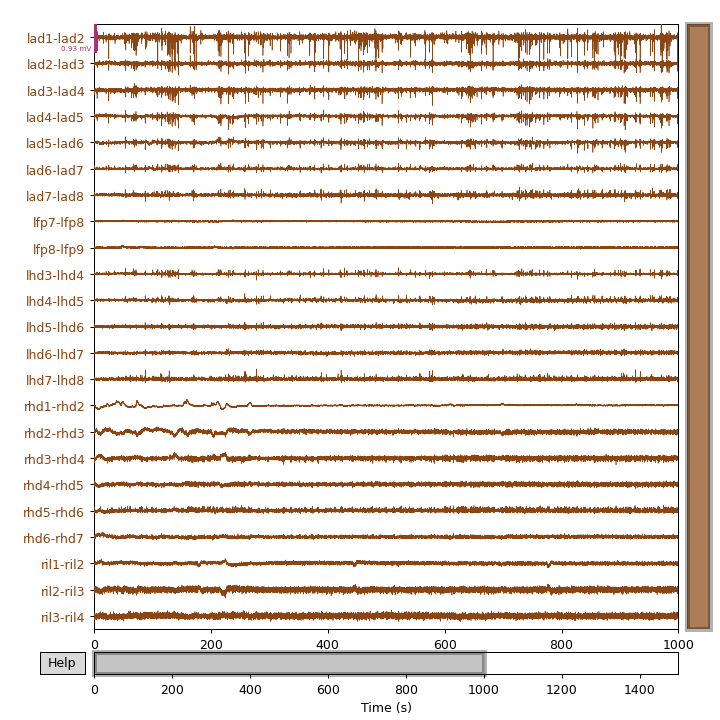

In [45]:
%matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=40, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


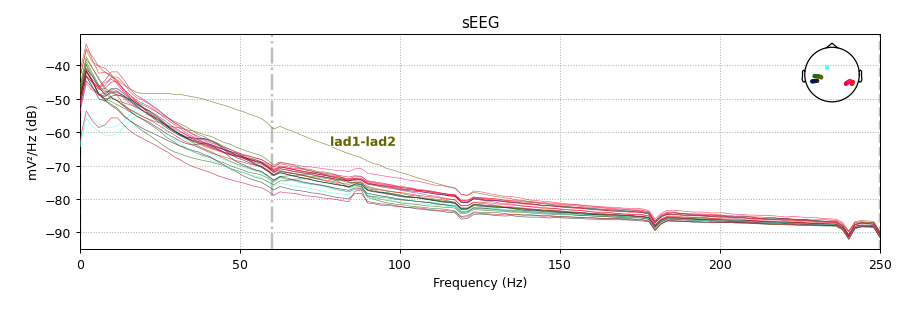

<IPython.core.display.Javascript object>


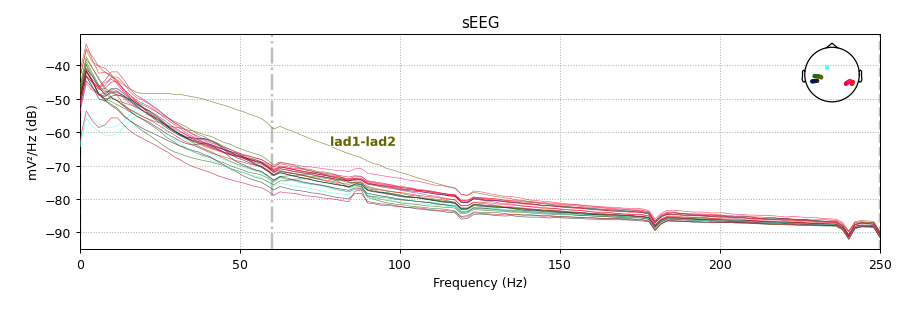

In [46]:
mne_data_bp_reref.compute_psd().plot()

In [47]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA9/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA9/bp_ref_ieeg.fif
[done]


## Save mne_data

In [48]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA9/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA9/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [49]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [51]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode_edf.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA9/photodiode_edf.fif...
Isotrak not found
    Range : 0 ... 1535999 =      0.000 ...  1499.999 secs
Ready.
Reading 0 ... 1535999  =      0.000 ...  1499.999 secs...


In [52]:
photodiode_data

<Raw | photodiode_edf.fif, 1 x 1536000 (1500.0 s), ~11.7 MB, data loaded>

In [75]:
### Photodiode alignment
smoothSize=45
windSize=10

height=2.25


# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)



512 blocks
......................................................................................................................................................................................................................................................................................................

KeyboardInterrupt: 

In [ ]:
print(slope,offset)

In [ ]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("Stim TEST2-REF")
# plt.plot(scipy.stats.zscore(mne_data._data[trig_ix,:]))
plt.plot(np.abs(mne_data._data[trig_ix,:]))
# plt.ylim([-2,2.5])
plt.xlim([400000,400500])
plt.title("Photodiode")
plt.show()

<IPython.core.display.Javascript object>


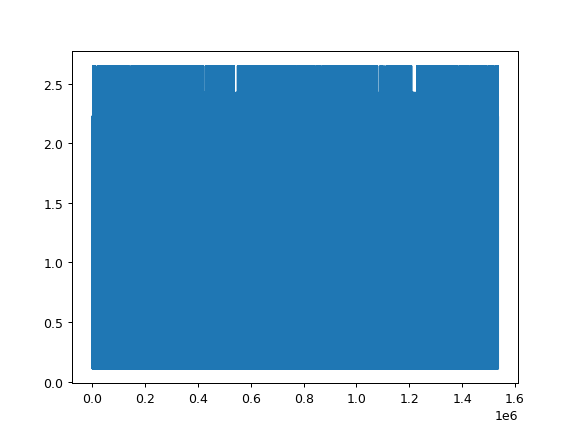

In [65]:
plt.plot(np.abs(scipy.stats.zscore(photodiode_data._data[0,:])))
# plt.plot(photodiode_data._data[0,:])
# plt.show()

In [66]:
temp_diode = photodiode_data.copy()
temp_data = np.abs(temp_diode._data[0,:])
# temp_data[temp_data>0.8] = -2
# temp_data[0:300000] = np.min(temp_data)
# temp_data[1100000:] = np.min(temp_data)
# temp_data[temp_data>4000] = 0
# temp_data = np.abs(temp_data-np.nanmax(temp_data)) #consider resaving photodiode 
# temp_data = np.abs(temp_diode._data[0, :])
# temp_data[0:1250000] = 0
temp_diode._data = temp_data

<IPython.core.display.Javascript object>


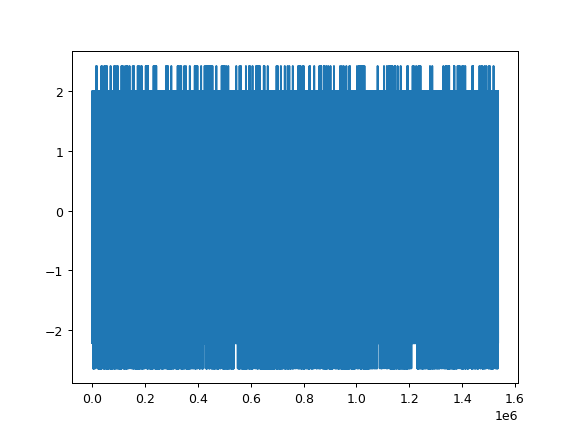

In [71]:
plt.plot(scipy.stats.zscore(temp_diode._data[:]))


In [76]:
#### verify photodiode alignment
    # requires newer functions from new sync utils package (older version used here)

def get_neural_ts_photodiode(mne_sync, smoothSize=11, height=0.5):
    """
    get neural ts from photodiode
    """

    sig = np.squeeze(moving_average(mne_sync._data, n=smoothSize))
    timestamp = np.squeeze(np.arange(len(sig))/mne_sync.info['sfreq'])
    sig = scipy.stats.zscore(sig)

    trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger
    
    neural_ts = timestamp[trig_ix]
    neural_ts = np.array(neural_ts)

    return neural_ts


def moving_average(a, n=11) :
    """
    Computes the moving average of a given array a with a window size of n.

    Parameters
    ----------
    a : np.ndarray
        The input array to compute the moving average on.
    n : int, optional
        The window size of the moving average. Default is 11.

    Returns
    -------
    np.ndarray
        The moving average of the input array a.
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n




In [84]:
neural_ts = get_neural_ts_photodiode(temp_diode, smoothSize=45, height=4)
neural_ts.shape

(17,)

<IPython.core.display.Javascript object>


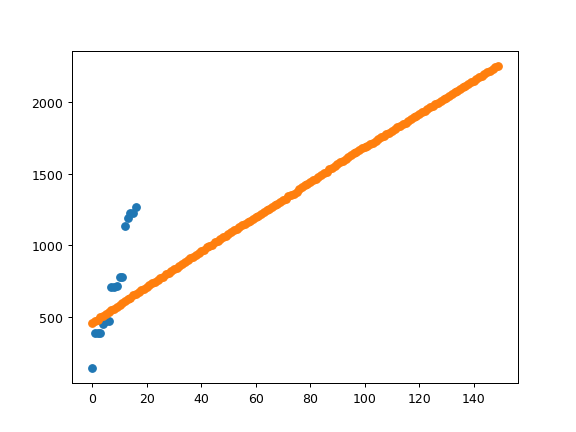

In [85]:
plt.plot(neural_ts,'o')
plt.plot(beh_ts,'o')

In [1049]:
nwin = len(beh_ts) - len(neural_ts)
rvals = []

slopes = [] 
offsets = []
for i in range(nwin+1):
    slope, offset, rval = sync_utils.sync_matched_pulses(beh_ts[i:len(neural_ts)+i].values, neural_ts)
    rvals.append(rval)
    slopes.append(slope)
    offsets.append(offset)
rvals = np.array(rvals)
offsets = np.array(offsets)
slopes = np.array(slopes)

In [1050]:
slope_diff = (np.abs(slopes - 1))
slope_diff
np.argmin(slope_diff)

15

In [1051]:
list(zip(rvals,slopes,offsets))

[(0.9999442227259411, 0.9884432561517804, 185.79901465349326),
 (0.9999421662636293, 0.9890572172703688, 173.32252907888744),
 (0.9999721072851037, 0.9898457615963617, 160.62794823100342),
 (0.9999467577453965, 0.9905433979181709, 147.9834041786906),
 (0.9999460398151515, 0.9912303850061603, 135.38132345947315),
 (0.9999772989035594, 0.9921014187561333, 122.52827133407533),
 (0.9999530953531591, 0.9928730066577033, 109.7379419917171),
 (0.9999523521590177, 0.9936339553678291, 97.00201483273429),
 (0.9999835832090781, 0.9945688493301126, 84.03379557710218),
 (0.9999596071500849, 0.9954048168817717, 71.12092388856468),
 (0.9999588402379246, 0.9960807354855457, 58.436963937598875),
 (0.9999908332859483, 0.9969726278247678, 45.44705563233231),
 (0.9999673083663726, 0.9977426478674698, 32.552595629130906),
 (0.9999660792559636, 0.9984653598118176, 19.767485593954802),
 (0.9999978183940783, 0.9993440125576212, 6.761011078306069),
 (0.9999727965160926, 1.000049275290768, -6.071292644149366),


In [1052]:
np.max(rvals)

0.9999978183940783

In [1053]:
offset = offsets[np.argmax(rvals)]
slope = slopes[np.argmax(rvals)]

print(slope,offset)

0.9993440125576212 6.761011078306069


<IPython.core.display.Javascript object>


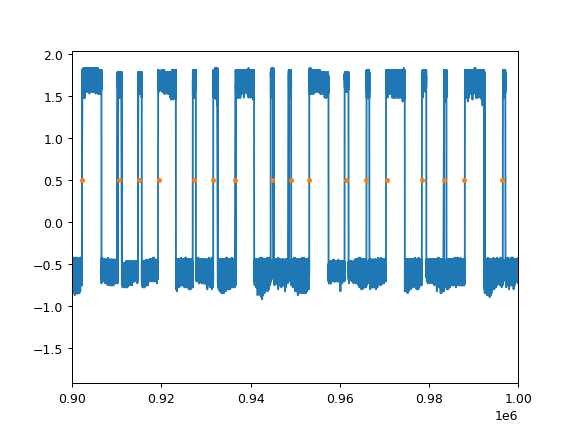

In [1056]:
pulses = [(x*slope + offset) for x in beh_ts]
plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
# plt.plot(pulses)
plt.plot(np.array(pulses)* photodiode_data.info['sfreq'], 
         np.ones_like(np.array(pulses) * photodiode_data.info['sfreq'])-0.5,'.')

plt.xlim([900000,1000000])
# plt.ylim([0,0.7])
plt.show()


In [1057]:
print(slope,offset)

0.9993440125576212 6.761011078306069


## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [1062]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [1063]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [1064]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [1065]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values,downsamp_factor=None,
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA8/bp_ref_ieeg.fif...
    Range : 0 ... 1139999 =      0.000 ...  2279.998 secs
Ready.
Reading 0 ... 1139999  =      0.000 ...  2279.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.3s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 27 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA8/bp_ref_ieeg.fif...
    Range : 0 ... 1139999 =      0.000 ...  2279.998 secs
Ready.
Reading 0 ... 1139999  =      0.000 ...  2279.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.0s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 27 columns


In [1066]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~46.4 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~108.2 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [353]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']


In [354]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 74 columns
Replacing existing metadata with 74 columns


In [355]:
epochs_all_evs[event].metadata

lam1-lam2 lam9-lam10 lhb1-lhb2 lhb2-lhb3 lhb3-lhb4 lhb7-lhb8 lhh1-lhh2  \
0         NaN        NaN       NaN       NaN       NaN       NaN       NaN   
1         NaN        NaN       NaN       NaN       NaN       NaN       NaN   
2         NaN        NaN       NaN       NaN       NaN       NaN       NaN   
3         NaN        NaN       NaN       NaN     noise       NaN       NaN   
4         NaN        NaN       NaN       NaN       NaN       NaN       NaN   
..        ...        ...       ...       ...       ...       ...       ...   
145       NaN        NaN       NaN       NaN       NaN       NaN       NaN   
146       NaN        NaN       NaN       NaN       NaN       NaN       NaN   
147       NaN        NaN       NaN       NaN       NaN       NaN       NaN   
148       NaN        NaN       NaN       NaN       NaN       NaN       NaN   
149       NaN        NaN       NaN       NaN       NaN       NaN       NaN   

     lhh2-lhh3 lhh3-lhh4 lhh8-lhh9  ... util_dCPE_emmap util_tCF_emmap  \
0    [427.374]       NaN       NaN  ...        1.473387      -1.473387   
1          NaN       NaN       NaN  ...        0.150880      -0.466413   
2          NaN       NaN       NaN  ...       -0.804410       0.804410   
3          NaN       NaN       NaN  ...        0.139378       0.000000   
4          NaN       NaN       NaN  ...        0.269242      -0.849062   
..         ...       ...       ...  ...             ...            ...   
145        NaN       NaN       NaN  ...        0.466413      -0.466413   
146      noise       NaN       NaN  ...       -1.698124       0.000000   
147        NaN       NaN       NaN  ...        0.068938       0.000000   
148        NaN       NaN       NaN  ...       -0.083765      -0.849062   
149        NaN       NaN       NaN  ...       -0.243672       0.470810   

    util_dCF_emmap util_tRegret_emmap util_dRegret_emmap util_tRelief_emmap  \
0        -1.473387           0.000000           0.000000           1.473387   
1         0.000000           0.000000           0.000000           0.617294   
2         0.804410          -0.804410          -0.804410           0.000000   
3         0.151460           0.000000           0.000000           0.290838   
4        -0.849062           0.000000           0.000000           0.269242   
..             ...                ...                ...                ...   
145      -0.466413           0.000000           0.000000           0.466413   
146       0.000000          -1.698124          -1.698124           0.000000   
147       0.243672           0.000000           0.000000           0.312610   
148      -0.849062           0.000000           0.000000          -0.083765   
149       0.243672          -0.470810          -0.243672           0.000000   

    util_dRelief_emmap  util_RPE_emmap  util_pRPE_emmap  util_nRPE_emmap  
0             1.473387        0.000000         0.000000          0.00000  
1             0.150880        0.466413         0.466413          0.00000  
2             0.000000        0.000000         0.000000          0.00000  
3             0.139378        0.000000         0.000000          0.00000  
4             0.269242        0.000000         0.000000          0.00000  
..                 ...             ...              ...              ...  
145           0.466413        0.000000         0.000000          0.00000  
146           0.000000        0.000000         0.000000          0.00000  
147           0.068938        0.000000         0.000000          0.00000  
148          -0.083765        0.000000         0.000000          0.00000  
149           0.000000       -0.470810         0.000000         -0.47081  

[150 rows x 74 columns]

### Save raw epoched data 

In [356]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [357]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [358]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


In [359]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [360]:
#baseline epoch - 
event = 'TrialOnset' #or baseline_ev
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

### this is new!
good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]


temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


Not setting metadata


In [361]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 16, ~275.3 MB>}

In [362]:
power_epochs = {}

In [363]:
event = 'DecisionOnset' # or analysis_evs

epochs = epochs_all_evs[event]

ch_names = epochs.ch_names

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names):
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'].data, 
                                                  mode='zscore',ev_axis=0,elec_axis=1,
                                                  freq_axis=2,time_axis=3)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



Not setting metadata
Not setting metadata
Adding metadata with 74 columns


In [364]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 16, ~1.34 GB>

In [365]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [366]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

01302024


In [306]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

-17.950900897248857


<IPython.core.display.Javascript object>


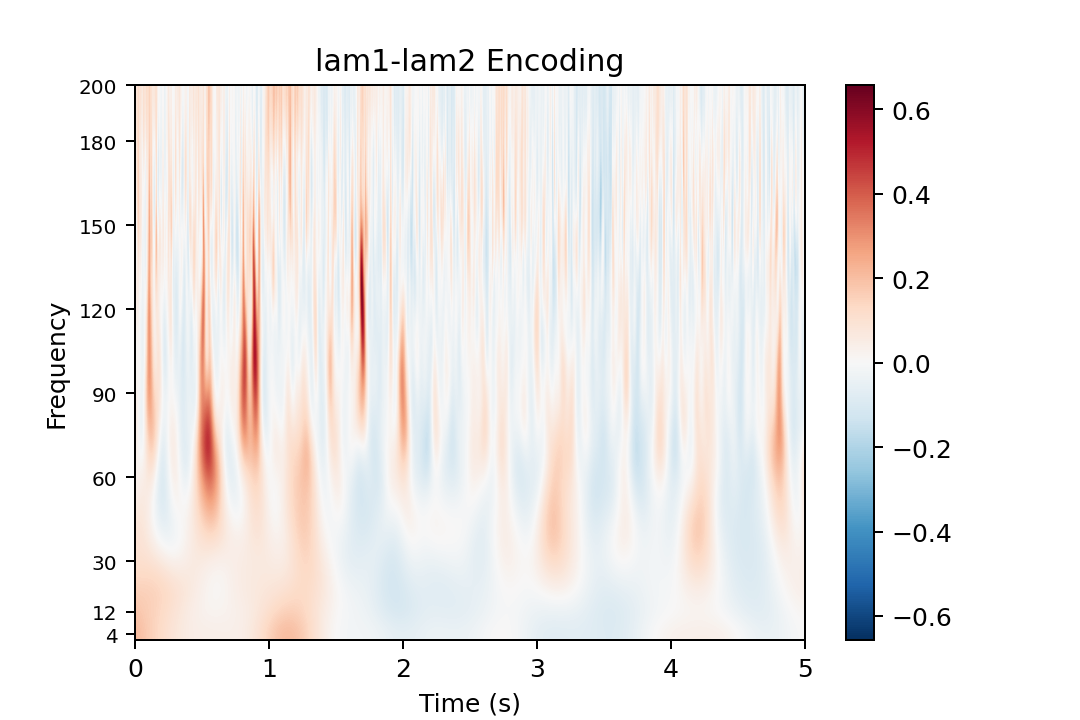

<IPython.core.display.Javascript object>


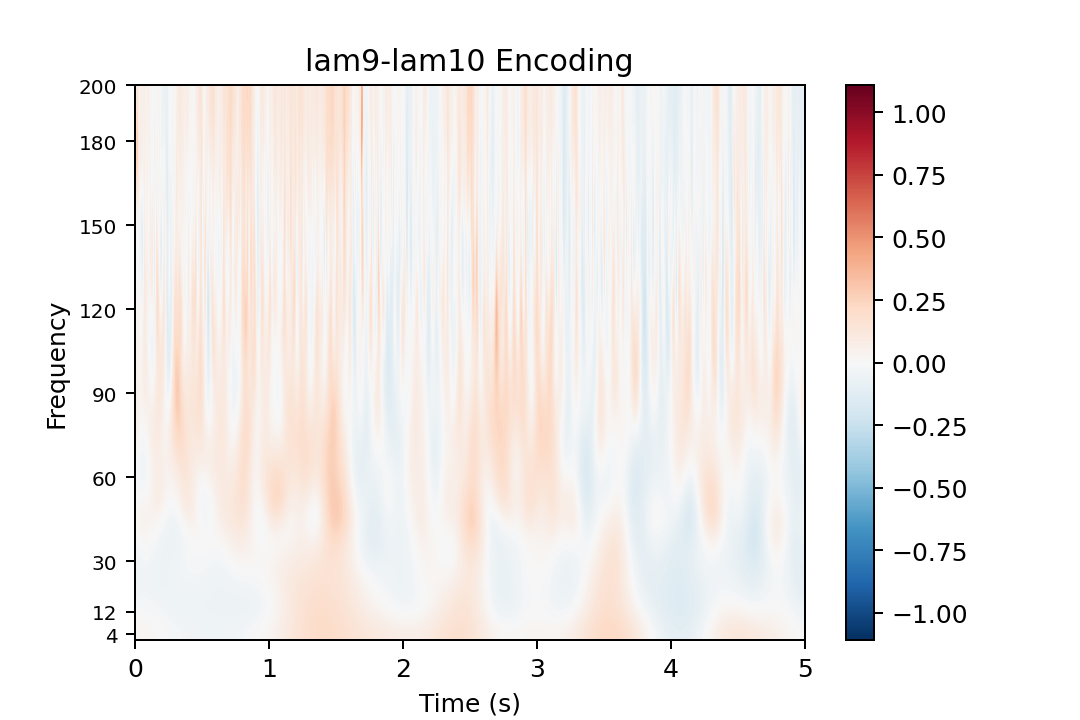

<IPython.core.display.Javascript object>


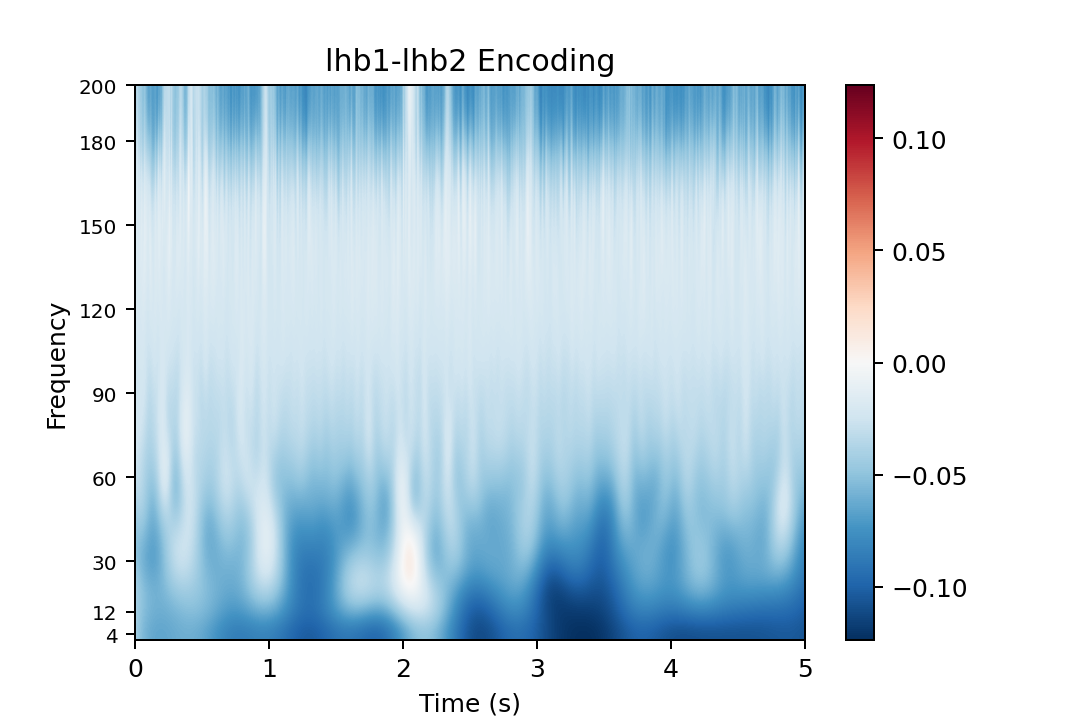

<IPython.core.display.Javascript object>


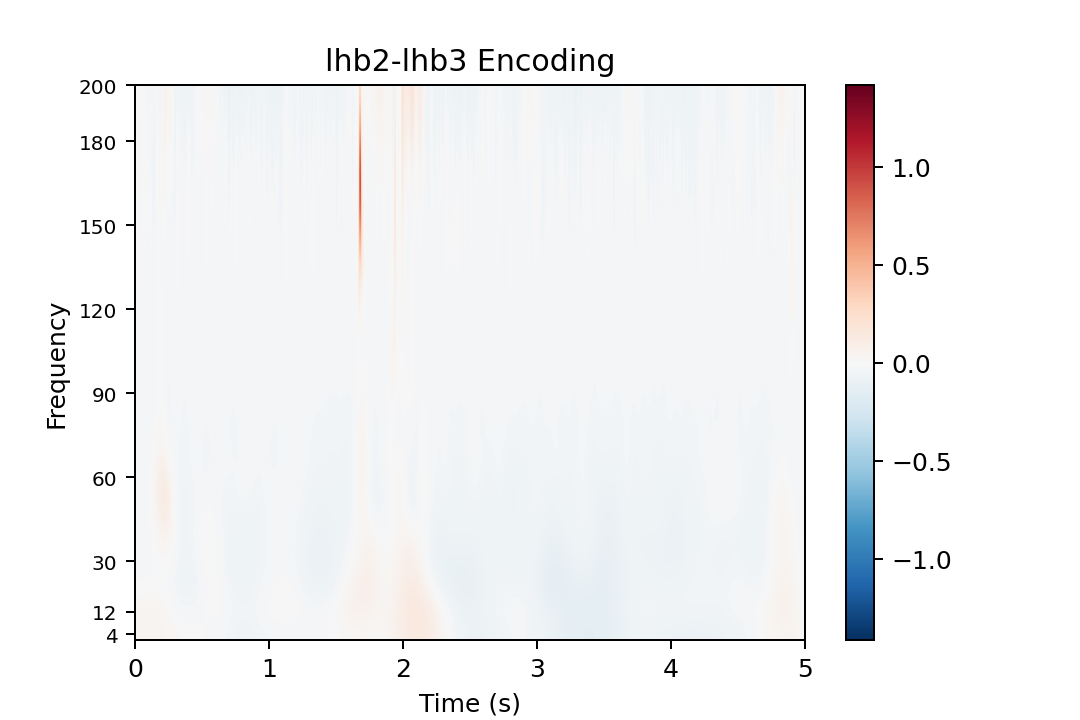

<IPython.core.display.Javascript object>


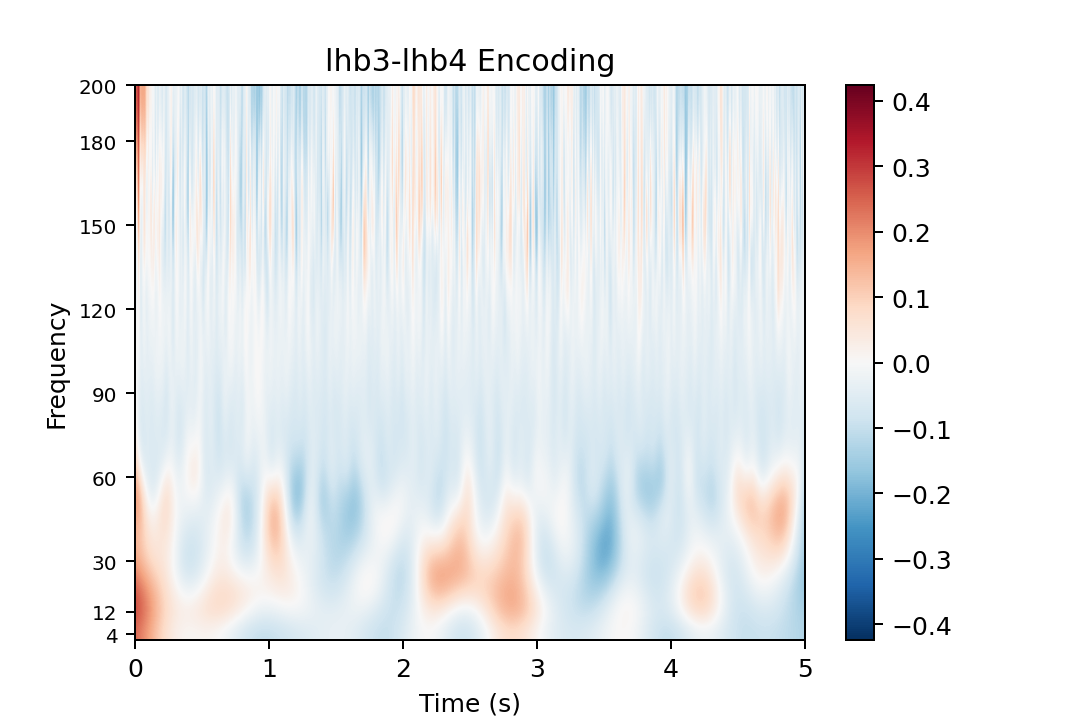

<IPython.core.display.Javascript object>


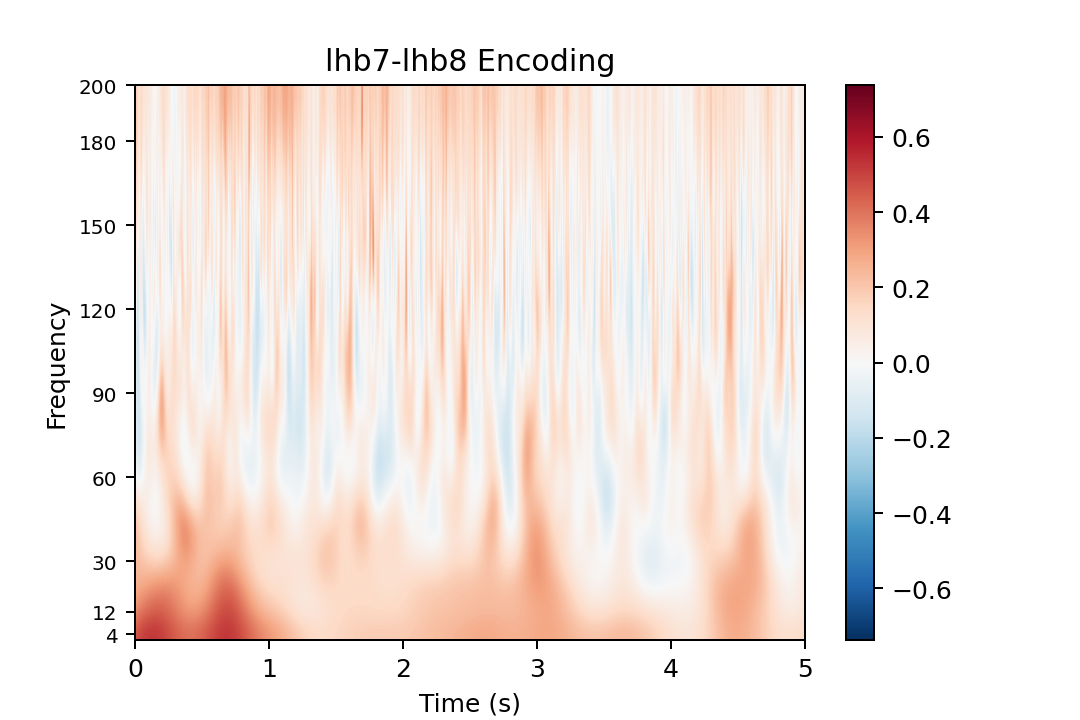

<IPython.core.display.Javascript object>


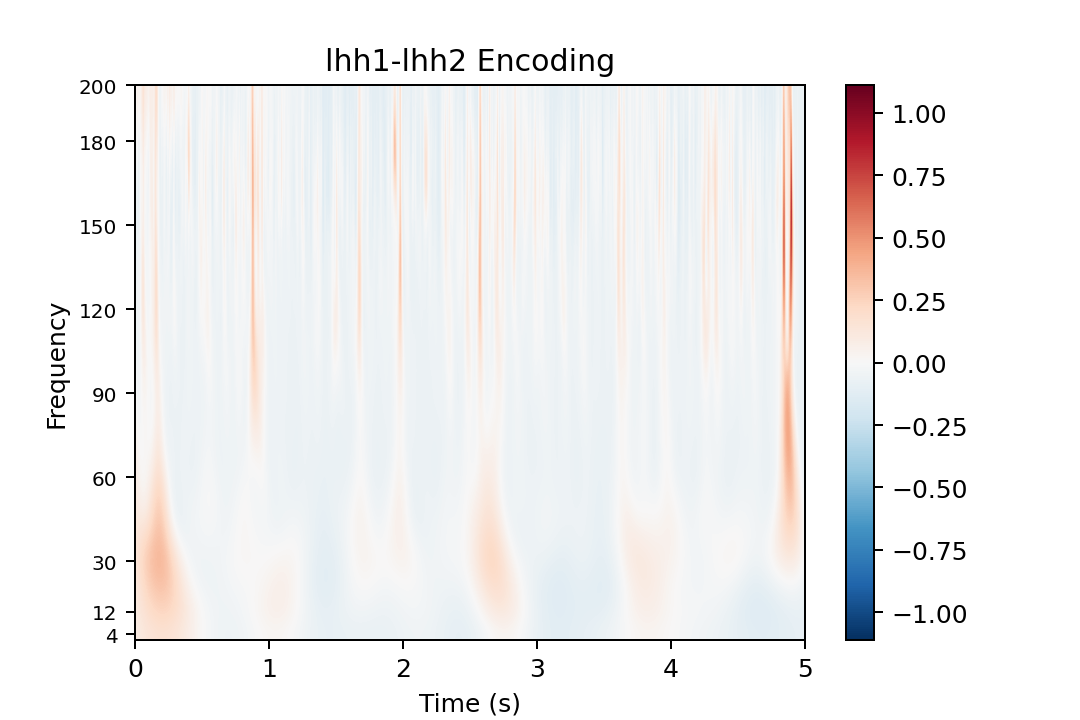

<IPython.core.display.Javascript object>


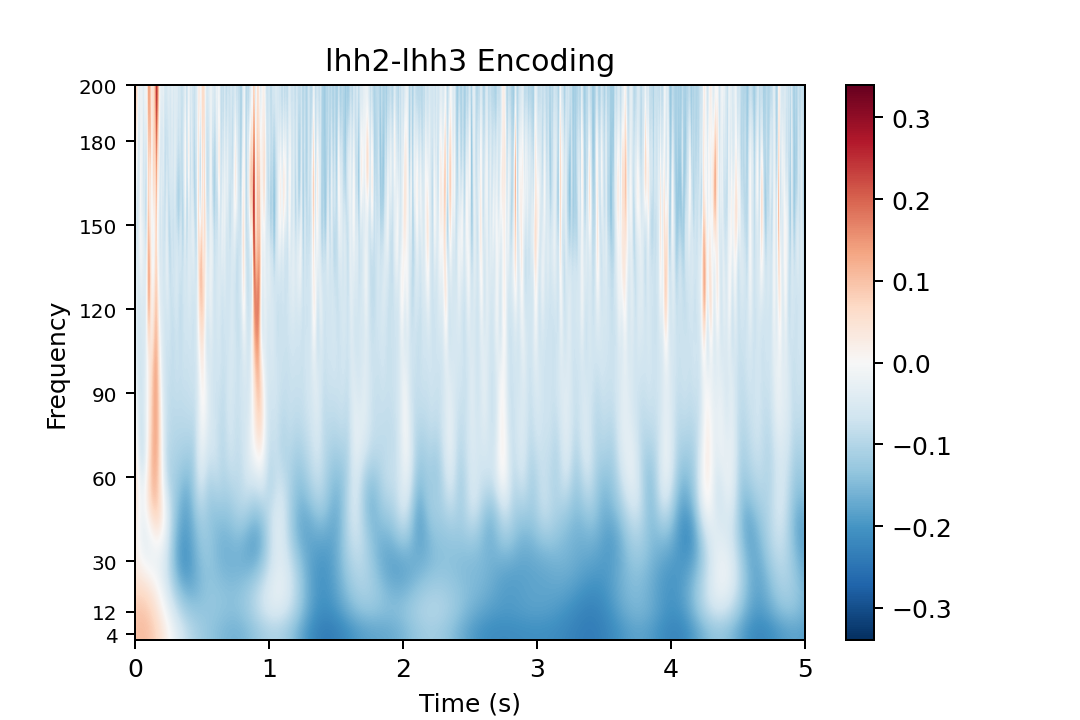

<IPython.core.display.Javascript object>


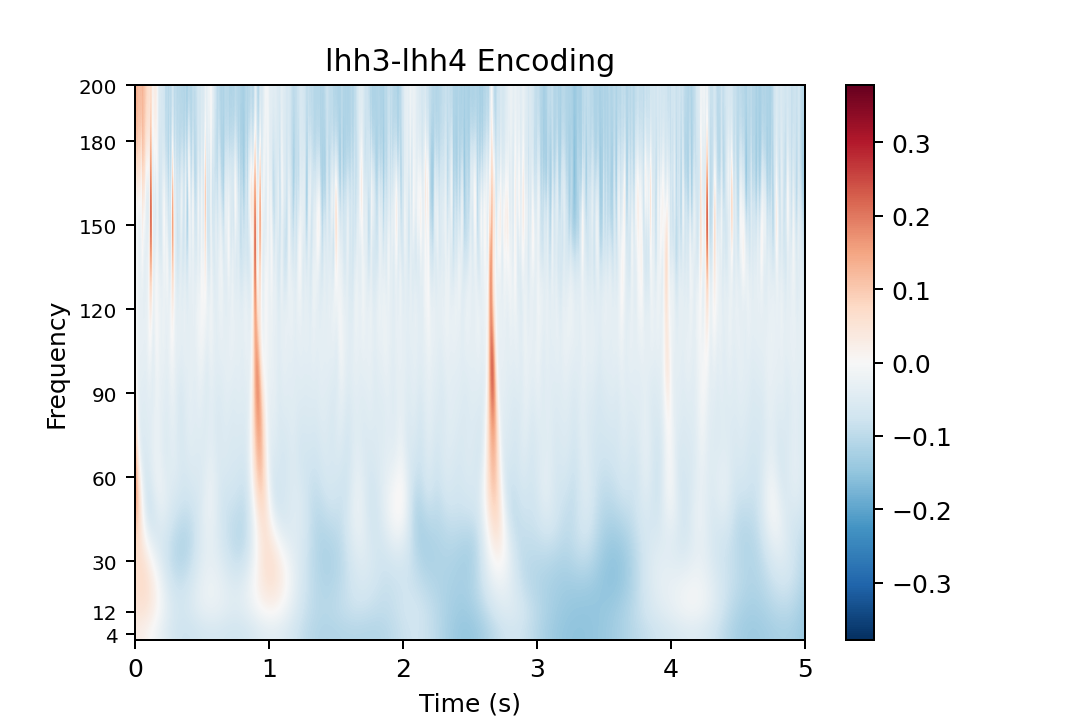

<IPython.core.display.Javascript object>


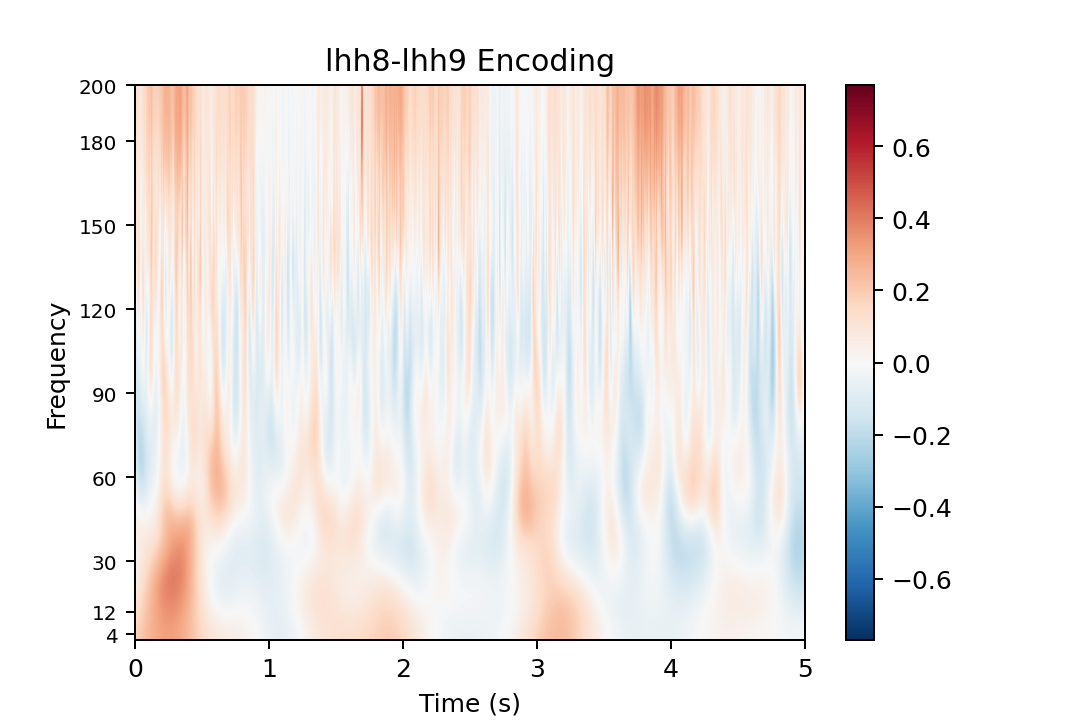

<IPython.core.display.Javascript object>


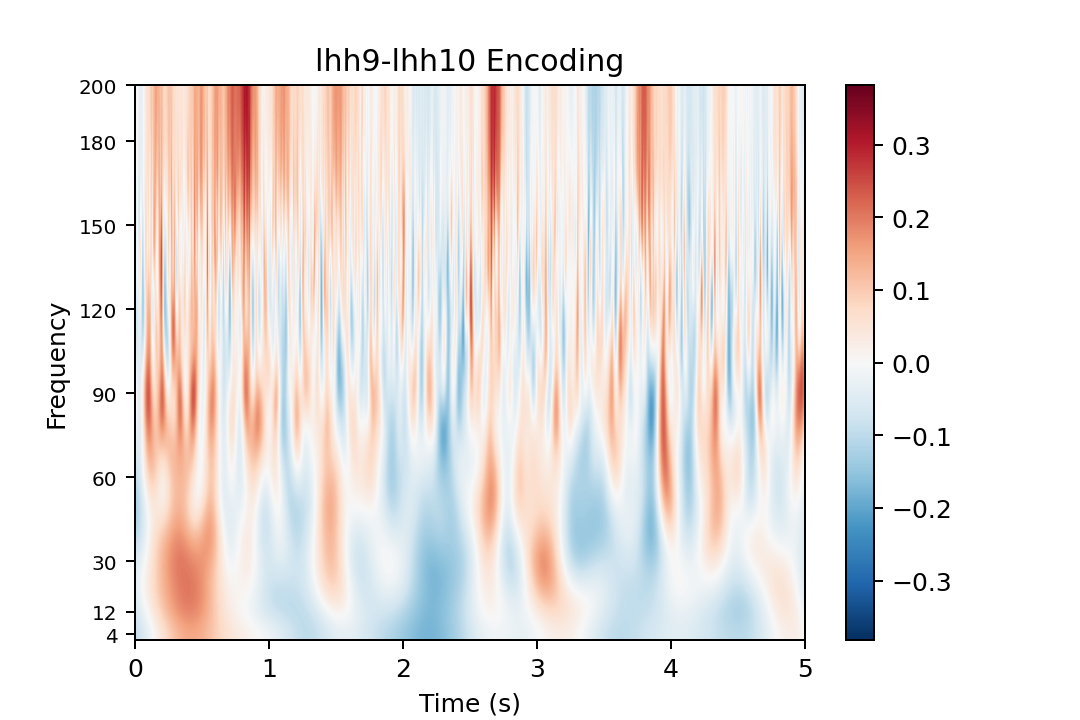

<IPython.core.display.Javascript object>


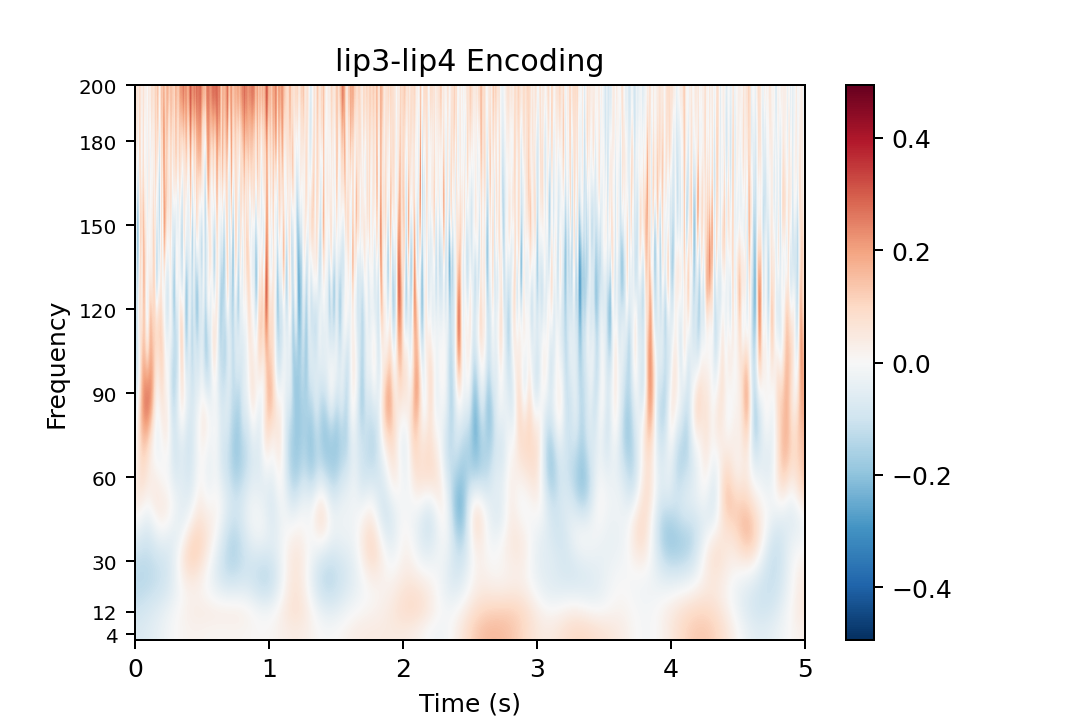

<IPython.core.display.Javascript object>


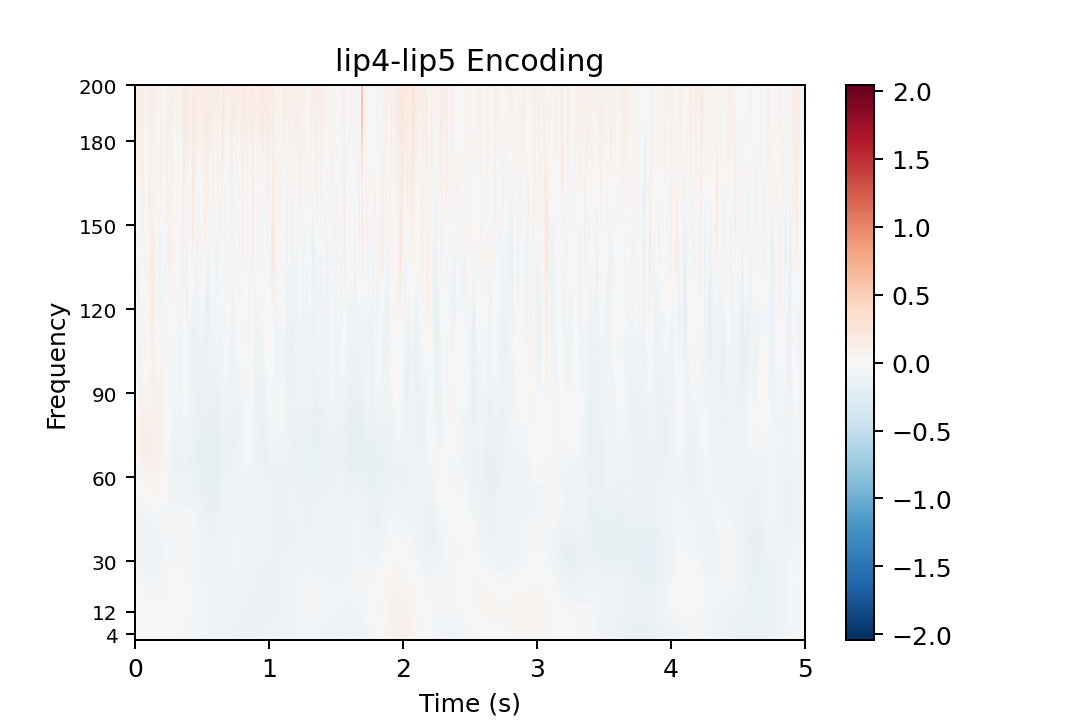

<IPython.core.display.Javascript object>


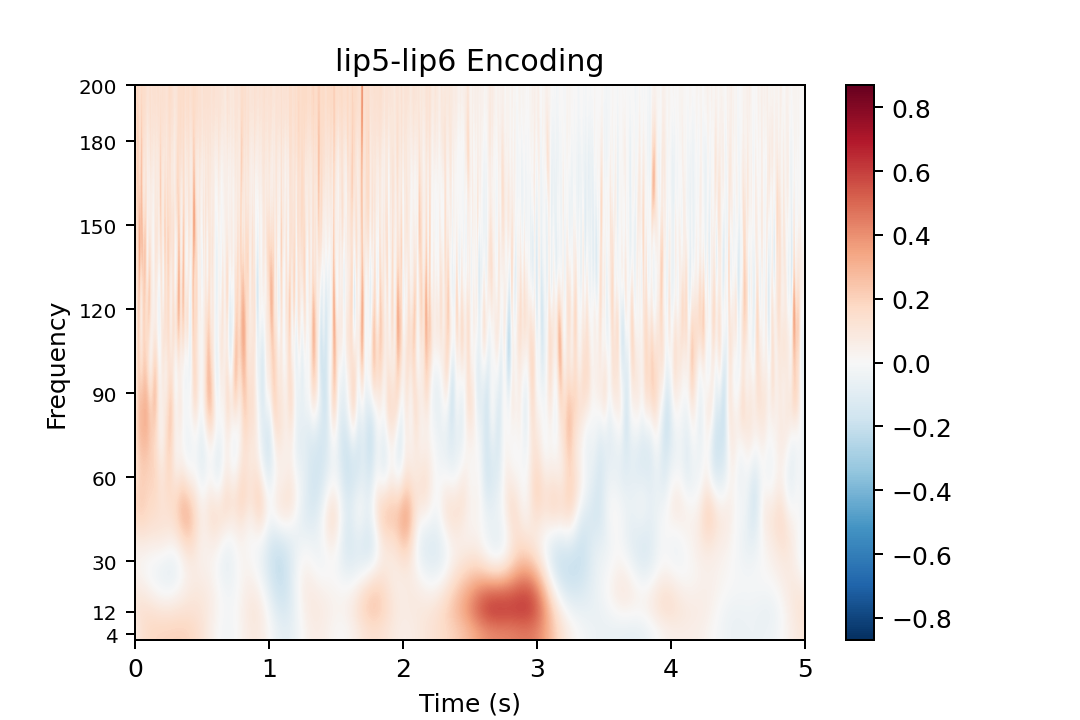

<IPython.core.display.Javascript object>


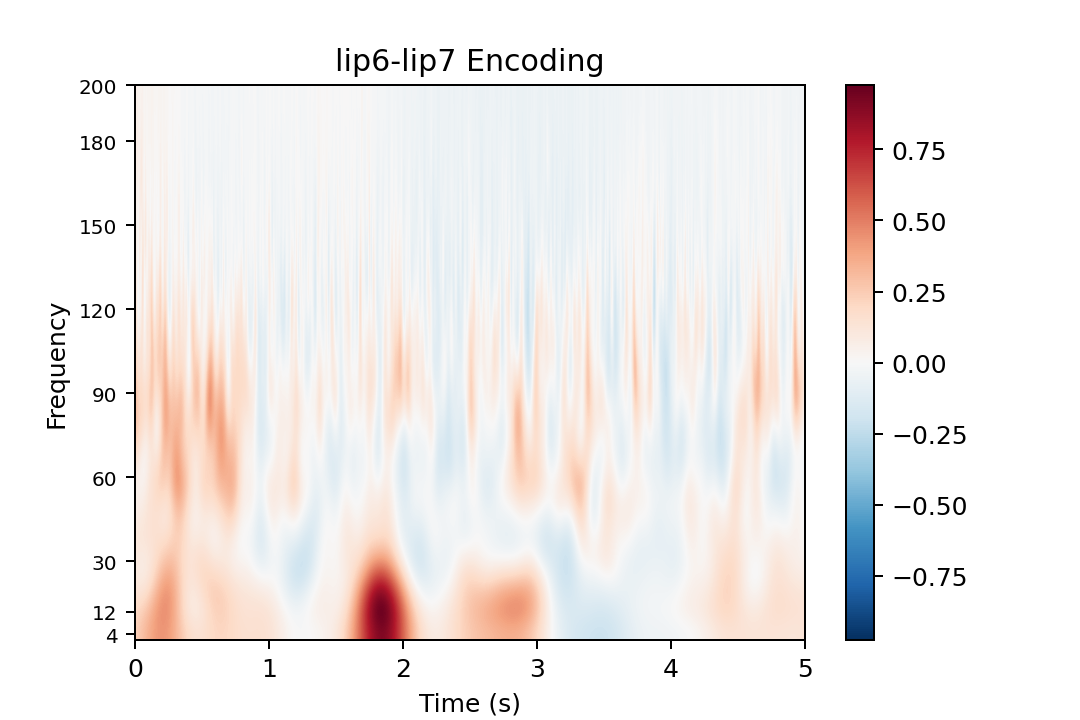

<IPython.core.display.Javascript object>


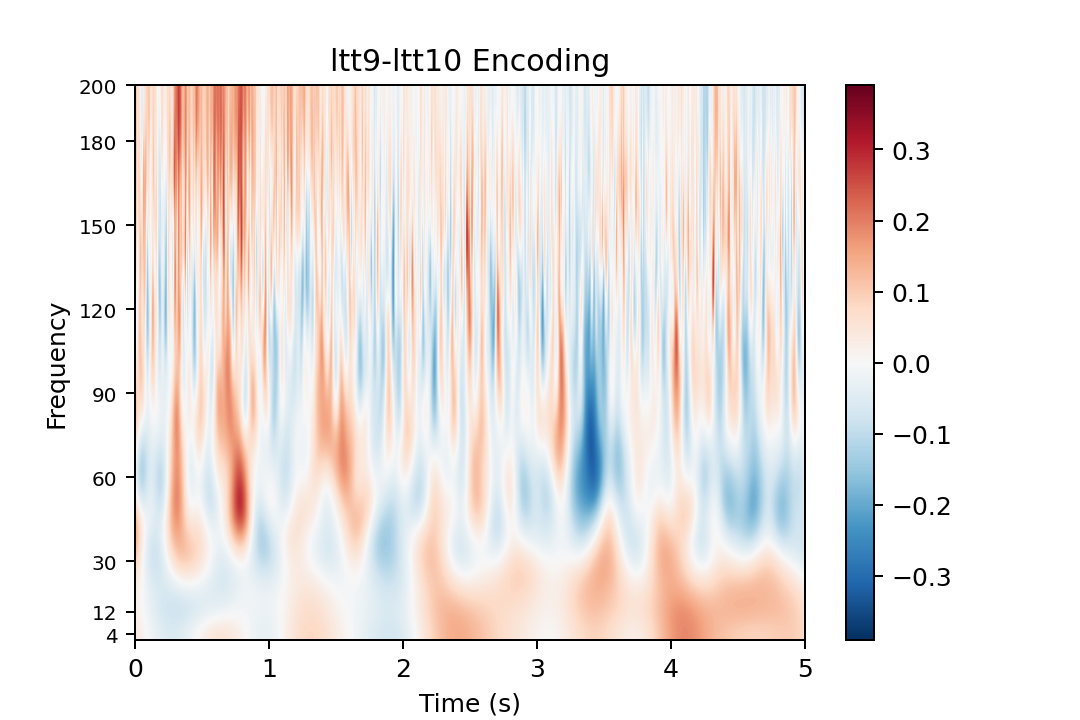

In [367]:
event = 'DecisionOnset'
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # same for all elec
    times = power_epochs[event].times
    # single ch tfr 
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), 
                   vmax = np.nanmax(np.abs(plot_data)))
    

    ax.set(xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding',
           yticks=np.arange(0,len(freqs))[::5], 
           yticklabels=freqs[::5].astype(int), 
           xticks = np.arange(plot_data.shape[1])[::250],
              xticklabels= times[::250])
    fig.colorbar(im, ax=ax)
    
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()
